## Initial imports

In [1]:
import scm.plams as plams
from scm.plams.tools.plot import plot_correlation, get_correlation_xy
import matplotlib.pyplot as plt

## Define two engines to compare

Here we choose GFNFF and GFN1-xTB

In [2]:
e1 = plams.Settings()
e1.input.GFNFF

e2 = plams.Settings()
e2.input.DFTB.Model = "GFN1-xTB"

Let's use a glycine molecule generated from SMILES:

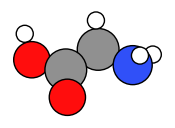

In [3]:
glycine = plams.from_smiles("C(C(=O)O)N")
plams.plot_molecule(glycine)

Run a single-point calculation storing the Gradients (negative forces):

In [4]:
sp = plams.Settings()
sp.input.ams.Task = "SinglePoint"
sp.input.ams.Properties.Gradients = "Yes"
sp.runscript.nproc = 1  # run in serial

In [5]:
job1 = plams.AMSJob(settings=sp + e1, name="glycine-engine1", molecule=glycine)
job2 = plams.AMSJob(settings=sp + e2, name="glycine-engine2", molecule=glycine)

In [6]:
job1.run()
job2.run()

[13.08|14:41:13] JOB glycine-engine1 STARTED
[13.08|14:41:13] JOB glycine-engine1 RUNNING
[13.08|14:41:14] JOB glycine-engine1 FINISHED
[13.08|14:41:15] JOB glycine-engine1 SUCCESSFUL
[13.08|14:41:15] JOB glycine-engine2 STARTED
[13.08|14:41:15] JOB glycine-engine2 RUNNING
[13.08|14:41:15] JOB glycine-engine2 FINISHED
[13.08|14:41:15] JOB glycine-engine2 SUCCESSFUL


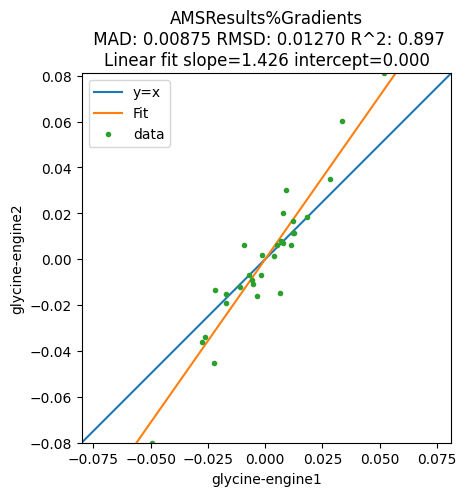

In [7]:
plot_correlation(
    job1,
    job2,
    section="AMSResults",
    variable="Gradients",
    file="engine",
);

To get the actual numbers, use ``get_correlation_xy``:

In [8]:
x, y = plams.tools.plot.get_correlation_xy(job1, job2, section="AMSResults", variable="Gradients", file="engine")
print("x")
print(x)
print("y")
print(y)

x
[-0.02618337 -0.02185398 -0.00569558 -0.00728149 -0.02743453  0.00760765
  0.02840358  0.05185629 -0.02249499 -0.00930743 -0.0496023   0.03370857
  0.00630104 -0.00342449 -0.00515473  0.01226365  0.01222411 -0.01690943
  0.00674109  0.01271709  0.01819203  0.00787463  0.00516595 -0.01108063
 -0.00154521  0.01105898  0.0037783  -0.01726648  0.00929288 -0.00195118]
y
[-0.03408318 -0.01360583 -0.00908411 -0.00699156 -0.0362322   0.01994845
  0.03482779  0.08117168 -0.04550755  0.00640144 -0.08007524  0.06008221
 -0.01476529 -0.01611956 -0.0109011   0.01657241  0.01123652 -0.01511969
  0.00813057  0.01138332  0.01821275  0.0071558   0.00602574 -0.0121942
  0.0019932   0.00620757  0.00153412 -0.01924117  0.03000799 -0.00697089]


## Compare multiple jobs

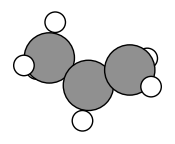

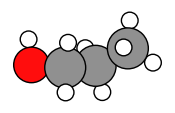

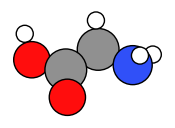

In [9]:
smiles_list = ["CC=C", "CCCO", "C(C(=O)O)N"]
names = ["propene", "propanol", "glycine"]
molecules = [plams.from_smiles(x) for x in smiles_list]
for mol in molecules:
    plams.plot_molecule(mol)

In [10]:
jobs1 = [plams.AMSJob(settings=sp + e1, name="e1" + name, molecule=mol) for name, mol in zip(names, molecules)]
jobs2 = [plams.AMSJob(settings=sp + e2, name="e2" + name, molecule=mol) for name, mol in zip(names, molecules)]

In [11]:
for job in jobs1 + jobs2:
    job.run()

[13.08|14:41:15] JOB e1propene STARTED
[13.08|14:41:15] JOB e1propene RUNNING
[13.08|14:41:15] JOB e1propene FINISHED
[13.08|14:41:15] JOB e1propene SUCCESSFUL
[13.08|14:41:15] JOB e1propanol STARTED
[13.08|14:41:15] JOB e1propanol RUNNING
[13.08|14:41:16] JOB e1propanol FINISHED
[13.08|14:41:16] JOB e1propanol SUCCESSFUL
[13.08|14:41:16] JOB e1glycine STARTED
[13.08|14:41:16] Job e1glycine previously run as glycine-engine1, using old results
[13.08|14:41:16] JOB e1glycine COPIED
[13.08|14:41:16] JOB e2propene STARTED
[13.08|14:41:16] JOB e2propene RUNNING
[13.08|14:41:16] JOB e2propene FINISHED
[13.08|14:41:16] JOB e2propene SUCCESSFUL
[13.08|14:41:16] JOB e2propanol STARTED
[13.08|14:41:16] JOB e2propanol RUNNING
[13.08|14:41:16] JOB e2propanol FINISHED
[13.08|14:41:16] JOB e2propanol SUCCESSFUL
[13.08|14:41:16] JOB e2glycine STARTED
[13.08|14:41:16] Job e2glycine previously run as glycine-engine2, using old results
[13.08|14:41:16] JOB e2glycine COPIED


The correlation plot can be plotted as before. You can also add a unit conversion to get your preferred units, and add custom xlabel and ylabel:

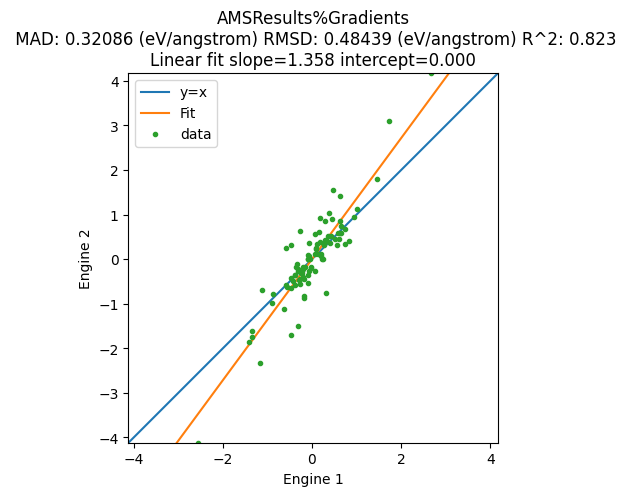

In [12]:
unit = "eV/angstrom"
multiplier = plams.Units.convert(1.0, "hartree/bohr", unit)

plot_correlation(
    jobs1,
    jobs2,
    section="AMSResults",
    variable="Gradients",
    file="engine",
    xlabel="Engine 1",
    ylabel="Engine 2",
    unit=unit,
    multiplier=multiplier,
);

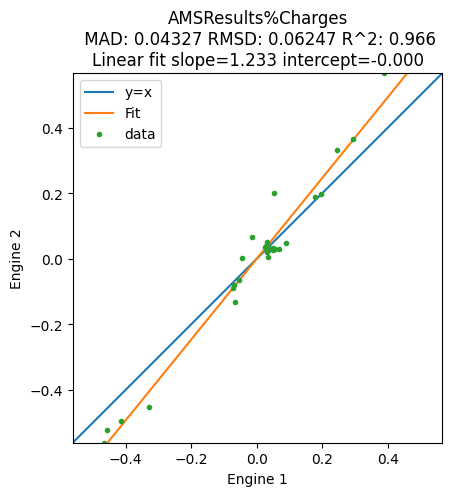

In [13]:
plot_correlation(
    jobs1,
    jobs2,
    section="AMSResults",
    variable="Charges",
    file="engine",
    xlabel="Engine 1",
    ylabel="Engine 2",
);

## Use Task Replay to compare multiple frames from a trajectory

The forces from an MD job can be stored with ``writeenginegradients=True``

In [14]:
md = plams.AMSNVEJob(
    settings=e1,
    name="nve-md-e1",
    molecule=glycine,
    velocities=400,
    nsteps=100,
    samplingfreq=10,
    writeenginegradients=True,
)
md.run()

[13.08|14:41:17] JOB nve-md-e1 STARTED
[13.08|14:41:17] JOB nve-md-e1 RUNNING
[13.08|14:41:17] JOB nve-md-e1 FINISHED
[13.08|14:41:17] JOB nve-md-e1 SUCCESSFUL


When using the Replay task, set ``Properties.Gradients`` to get the forces:

In [15]:
replay_s = plams.Settings()
replay_s.input.ams.Task = "Replay"
replay_s.input.ams.Properties.Gradients = "Yes"
replay_s.input.ams.Replay.File = md.results.rkfpath()
replay = plams.AMSJob(settings=e2 + replay_s, name="replay-e2")
replay.run()

[13.08|14:41:17] JOB replay-e2 STARTED
[13.08|14:41:17] JOB replay-e2 RUNNING
[13.08|14:41:19] JOB replay-e2 FINISHED
[13.08|14:41:19] JOB replay-e2 SUCCESSFUL


For the MD job the gradients (negative forces) are stored in ``History%EngineGradients``, but for the Replay job they are stored in ``History%Gradients``. Use the ``alt_variable`` to specify the variable for the second job:

<AxesSubplot: title={'center': 'History%EngineGradients\n MAD: 0.00856 RMSD: 0.01171 R^2: 0.724\nLinear fit slope=0.987 intercept=0.000'}, xlabel='nve-md-e1', ylabel='replay-e2'>

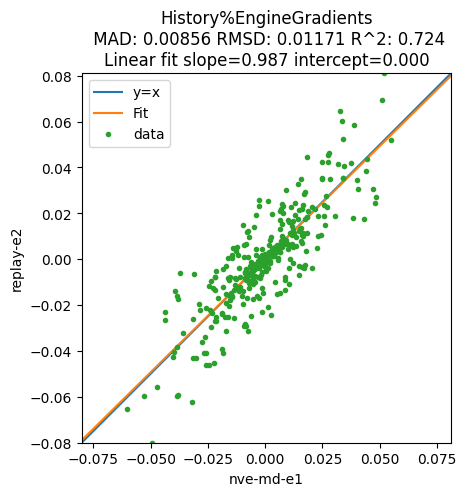

In [16]:
plot_correlation(md, replay, section="History", variable="EngineGradients", alt_variable="Gradients", file="ams")